In [2]:
import os
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters, exposure, morphology
from skimage.morphology import remove_small_objects, remove_small_holes, binary_closing, ball
from skimage.morphology import binary_opening, disk
from skimage.morphology import black_tophat, disk
from skimage.filters import threshold_sauvola
from skimage.measure import label, regionprops
from skimage.morphology import remove_small_holes
from skimage.measure import label, regionprops
from skimage.measure import label
from skimage.color import label2rgb
from skimage.filters import median
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border

In [3]:
# Define location of image stack
stack_path = 'image_stacks/purk_dend_mito_9381230019597'

# Create a folder for export files
normalized_path = os.path.normpath(stack_path)
base, last_folder = os.path.split(normalized_path)
export_path = os.path.join(base, last_folder + '_seg')

# Check if the folder exists; if not, create it.
if not os.path.exists(export_path):
    os.makedirs(export_path)
    print(f"Folder created: {export_path}")
else:
    print(f"Folder already exists: {export_path}")


Folder already exists: image_stacks\purk_dend_mito_9381230019597_seg


In [3]:
# from pathlib import Path
# from PIL import Image

# Define the path to your stack directory
stack_path = Path(stack_path)  # Replace with your actual directory

# List all PNG files in the directory
png_files = list(stack_path.glob('*.png'))

# Helper function to extract the z-value from the filename.
def extract_z_value(file_path: Path) -> int:
    # Split the filename (without extension) on underscore.
    parts = file_path.stem.split('_')
    try:
        # Always use the last element as the z-value.
        return int(parts[-1])
    except ValueError:
        raise ValueError(f"Expected the last part of the filename {file_path.name} to be an integer.")

# Sort the files based on the extracted z-value
png_files_sorted = sorted(png_files, key=extract_z_value)

# Create a dictionary where each key is the z-value and the value is the corresponding image.
images_dict = {}
for file_path in png_files_sorted:
    z_value = extract_z_value(file_path)
    images_dict[z_value] = Image.open(file_path)

# Example: Print the keys (z-values) in the dictionary
print("Z-values:", list(images_dict.keys()))


Z-values: [395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443]


In [4]:
images_dict

{395: <PIL.PngImagePlugin.PngImageFile image mode=L size=2048x2048>,
 396: <PIL.PngImagePlugin.PngImageFile image mode=L size=2048x2048>,
 397: <PIL.PngImagePlugin.PngImageFile image mode=L size=2048x2048>,
 398: <PIL.PngImagePlugin.PngImageFile image mode=L size=2048x2048>,
 399: <PIL.PngImagePlugin.PngImageFile image mode=L size=2048x2048>,
 400: <PIL.PngImagePlugin.PngImageFile image mode=L size=2048x2048>,
 401: <PIL.PngImagePlugin.PngImageFile image mode=L size=2048x2048>,
 402: <PIL.PngImagePlugin.PngImageFile image mode=L size=2048x2048>,
 403: <PIL.PngImagePlugin.PngImageFile image mode=L size=2048x2048>,
 404: <PIL.PngImagePlugin.PngImageFile image mode=L size=2048x2048>,
 405: <PIL.PngImagePlugin.PngImageFile image mode=L size=2048x2048>,
 406: <PIL.PngImagePlugin.PngImageFile image mode=L size=2048x2048>,
 407: <PIL.PngImagePlugin.PngImageFile image mode=L size=2048x2048>,
 408: <PIL.PngImagePlugin.PngImageFile image mode=L size=2048x2048>,
 409: <PIL.PngImagePlugin.PngImage

In [5]:
len(images_dict)

49

In [6]:
# Create 3D numpy array

# import numpy as np
# from PIL import Image
# import skimage.filters
# import skimage.morphology
# import skimage.measure

# Suppose images_dict = {z_value: <PIL image>, ...}
# Sort the z-values
z_values = sorted(images_dict.keys())

# Convert each PIL image to a NumPy array and stack them along a new axis.
# We'll assume the shape is (Z, Y, X).
stack_3d = np.array([np.array(images_dict[z]) for z in z_values], dtype=np.uint8)


In [7]:
stack_3d

array([[[103, 116, 116, ..., 212, 204, 198],
        [104, 123, 133, ..., 222, 212, 213],
        [136, 120, 135, ..., 230, 196, 202],
        ...,
        [170, 164, 133, ..., 180, 173, 164],
        [147, 159, 127, ..., 185, 167, 177],
        [152, 153, 121, ..., 191, 177, 181]],

       [[156, 134, 110, ..., 127, 171, 162],
        [156, 141, 114, ..., 139, 150, 157],
        [174, 158, 131, ..., 154, 154, 139],
        ...,
        [148, 150, 127, ..., 115, 136, 155],
        [158, 159, 133, ..., 109, 115, 137],
        [161, 156, 128, ..., 105, 118, 140]],

       [[ 45,  51,  53, ..., 207, 198, 188],
        [ 10,  13,  38, ..., 212, 208, 205],
        [ 30,  32,  43, ..., 215, 224, 223],
        ...,
        [182, 174, 186, ...,  64,  67,  56],
        [209, 191, 193, ...,  64,  77,  83],
        [208, 208, 193, ...,  95, 103,  92]],

       ...,

       [[ 89,  85, 115, ...,  40,  51,  52],
        [ 85,  85,  97, ...,  46,  51,  44],
        [ 86,  82,  92, ...,  59,  58,  53

In [10]:
# Apply median filter

# from skimage.filters import median
# from skimage.morphology import disk

# For each slice in the stack, apply a 2D median filter
stack_median = np.empty_like(stack_3d, dtype=np.float64)
for i in range(stack_3d.shape[0]):
    stack_median[i] = median(stack_3d[i], disk(2))


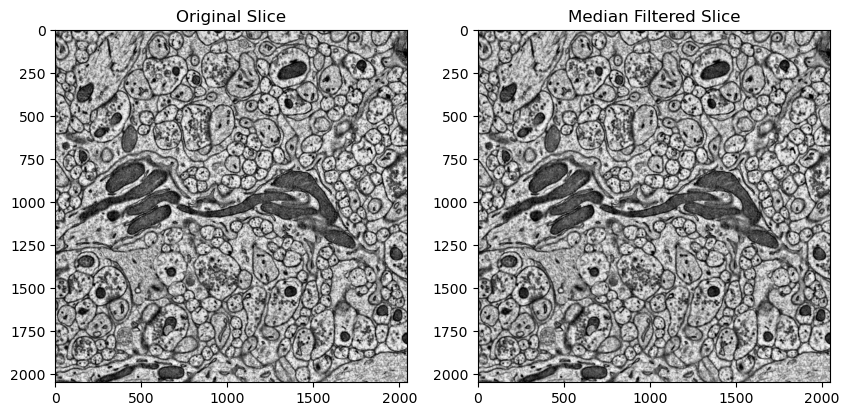

In [11]:
# Inspect median filter

# import matplotlib.pyplot as plt

# Choose a slice index to visualize; for example, the middle slice
slice_index = stack_3d.shape[0] // 2

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Original slice
axes[0].imshow(stack_3d[slice_index], cmap='gray')
axes[0].set_title("Original Slice")

# Median-filtered slice
axes[1].imshow(stack_median[slice_index], cmap='gray')
axes[1].set_title("Median Filtered Slice")

plt.show()


In [15]:
# Thresholding using otsu 

# from skimage.filters import threshold_otsu

# Compute a single Otsu threshold across the entire volume
global_thresh = threshold_otsu(stack_median)
binary_stack = stack_median < global_thresh  # Mito are dark, so invert the comparison


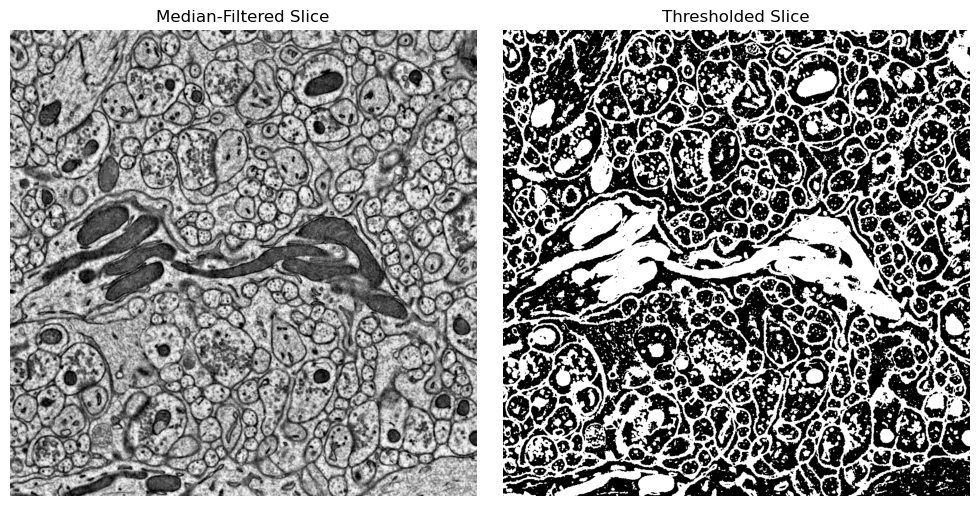

In [16]:
# Inspect Thresholding

# import matplotlib.pyplot as plt

# Choose a slice index to visualize, e.g., the middle slice
slice_index = stack_median.shape[0] // 2

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Show the original (or median-filtered) slice
axes[0].imshow(stack_median[slice_index], cmap='gray')
axes[0].set_title("Median-Filtered Slice")
axes[0].axis("off")

# Show the thresholded result (binary)
axes[1].imshow(binary_stack[slice_index], cmap='gray')
axes[1].set_title("Thresholded Slice")
axes[1].axis("off")

plt.tight_layout()
plt.show()


In [60]:
# Attempt breaking up the cell membrane by erosion

import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import opening, ball
from skimage.measure import label, regionprops

# (1) Morphological opening in 3D
# Erosion followed by dilation with a spherical structuring element of radius=1
binary_stack_opened = opening(binary_stack, ball(4))



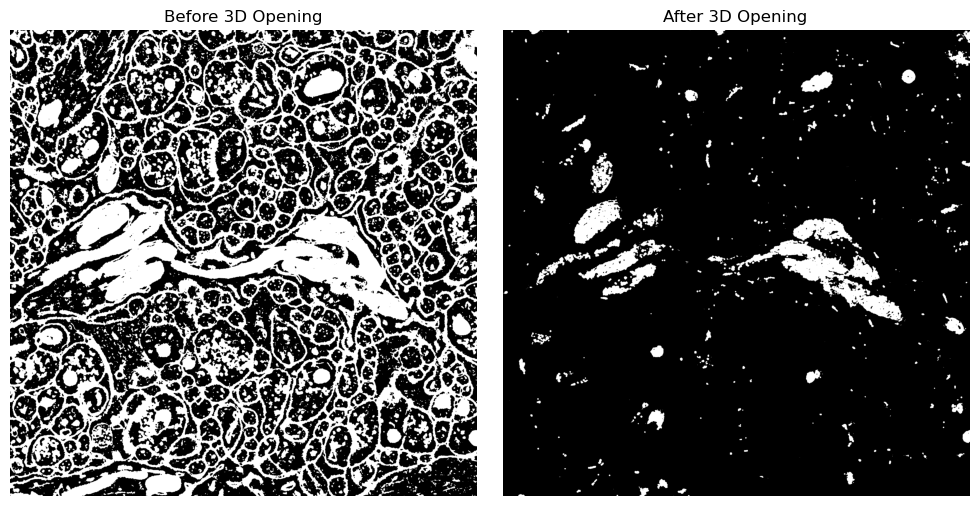

Number of objects after 3D opening: 2743
Object 1: label=1, volume=91 voxels, bbox=(0, 0, 49, 5, 5, 58)
Object 2: label=2, volume=8058 voxels, bbox=(0, 0, 124, 7, 40, 202)
Object 3: label=3, volume=664 voxels, bbox=(0, 0, 564, 14, 6, 584)
Object 4: label=4, volume=282 voxels, bbox=(0, 0, 740, 5, 9, 753)
Object 5: label=5, volume=72332 voxels, bbox=(0, 0, 929, 28, 79, 1015)
Object 6: label=6, volume=48233 voxels, bbox=(0, 0, 1131, 10, 129, 1236)
Object 7: label=7, volume=1698 voxels, bbox=(0, 0, 1229, 6, 19, 1256)
Object 8: label=8, volume=12551 voxels, bbox=(0, 0, 1566, 13, 35, 1635)
Object 9: label=9, volume=2463 voxels, bbox=(0, 0, 1747, 15, 30, 1776)
Object 10: label=10, volume=77538 voxels, bbox=(0, 0, 304, 17, 139, 422)
Object 11: label=11, volume=531 voxels, bbox=(0, 4, 862, 5, 21, 880)
Object 12: label=12, volume=16204 voxels, bbox=(0, 0, 533, 18, 64, 594)
Object 13: label=13, volume=760 voxels, bbox=(0, 7, 678, 6, 26, 695)
Object 14: label=14, volume=358 voxels, bbox=(0, 8, 140

In [61]:
# (2) Visual inspection: Compare the middle slice before vs. after opening
slice_index = binary_stack_opened.shape[0] // 2

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(binary_stack[slice_index], cmap='gray')
axes[0].set_title("Before 3D Opening")
axes[0].axis("off")

axes[1].imshow(binary_stack_opened[slice_index], cmap='gray')
axes[1].set_title("After 3D Opening")
axes[1].axis("off")

plt.tight_layout()
plt.show()

# (3) Programmatic inspection: Label and list the first few connected components
labeled_opened = label(binary_stack_opened, connectivity=3)
props_opened = regionprops(labeled_opened)

print(f"Number of objects after 3D opening: {len(props_opened)}")
for i, region in enumerate(props_opened[:15], start=1):
    print(f"Object {i}: label={region.label}, volume={region.area} voxels, bbox={region.bbox}")


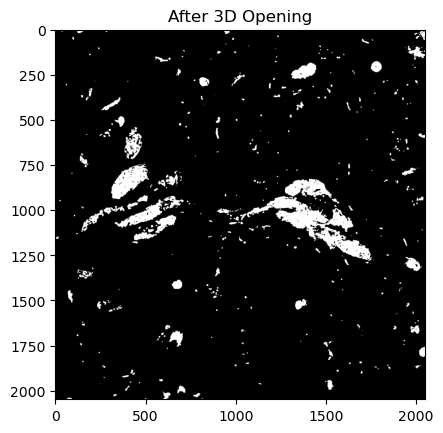

In [68]:
slice_index = binary_stack_opened.shape[0] // 2
plt.imshow(binary_stack_opened[slice_index], cmap='gray')
plt.title("After 3D Opening")
plt.show()

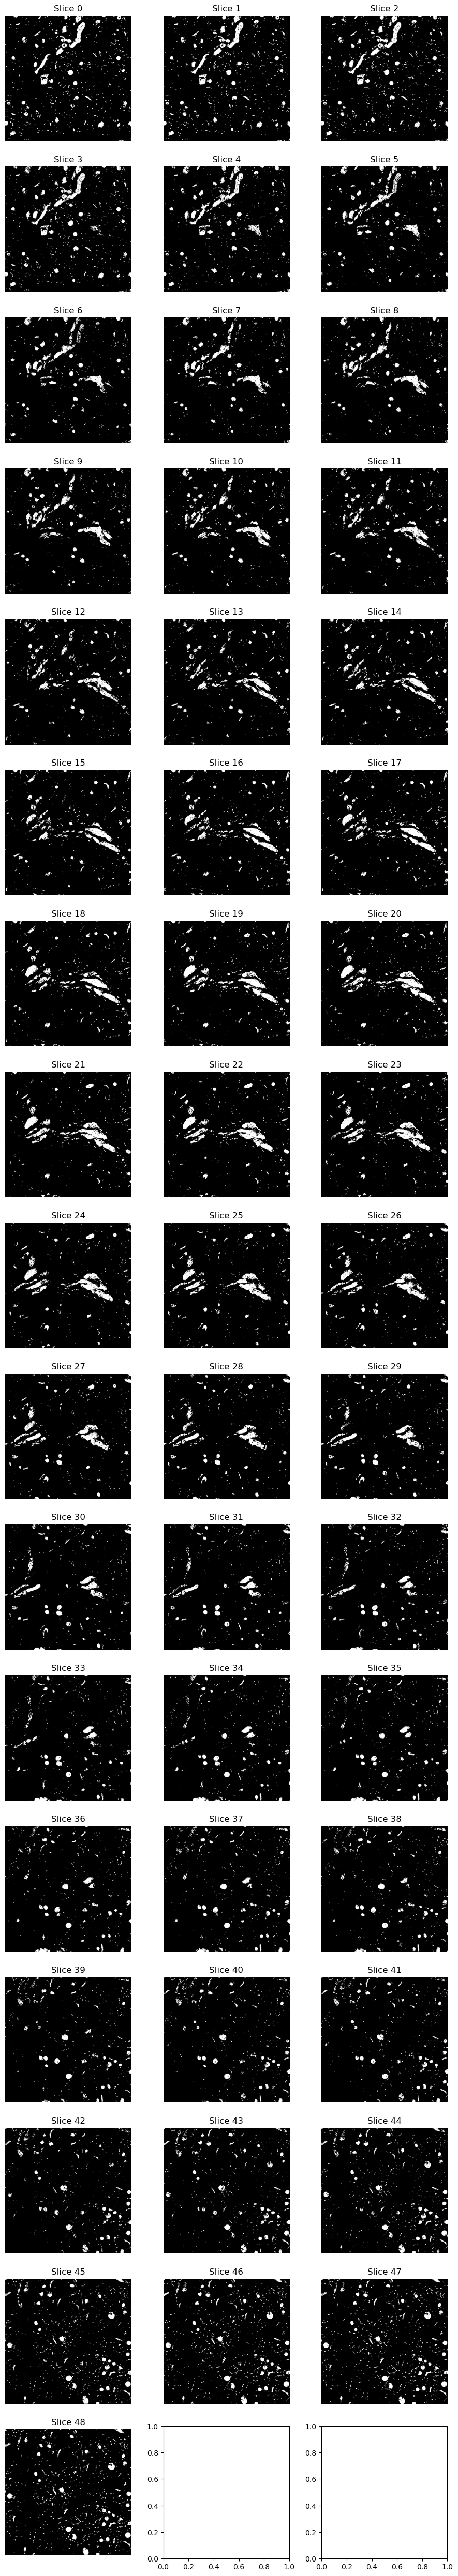

In [69]:
# import matplotlib.pyplot as plt

# We assume eroded_stack has 49 slices: eroded_stack.shape[0] == 49
num_slices = binary_stack_opened.shape[0]
assert num_slices == 49, f"Expected 49 slices, but found {num_slices}."

# Create a figure with 17 rows and 3 columns
fig, axes = plt.subplots(nrows=17, ncols=3, figsize=(9, 50))

# Loop over each slice and display it in the appropriate subplot
for i in range(num_slices):
    row = i // 3
    col = i % 3
    axes[row, col].imshow(binary_stack_opened[i], cmap='gray')
    axes[row, col].set_title(f"Slice {i}")
    axes[row, col].axis("off")

plt.tight_layout()
plt.show()


In [70]:
# Generate labels

import numpy as np
from skimage.measure import label, regionprops

# binary_stack_opened: 3D NumPy array (bool or 0/1) after morphological opening
labeled_stack = label(binary_stack_opened, connectivity=3)

print("Total labeled objects:", labeled_stack.max())


Total labeled objects: 2743


In [71]:
# Remove small objects

import copy

# Make a copy if you want to preserve the original labels
labeled_stack_filtered = copy.deepcopy(labeled_stack)
props = regionprops(labeled_stack_filtered)
min_voxel_count = 1000  # Adjust to remove small fragments

for region in props:
    if region.area < min_voxel_count:
        # Zero out (remove) this label
        labeled_stack_filtered[labeled_stack_filtered == region.label] = 0

# Re-label so labels are consecutive
labeled_stack_filtered = label(labeled_stack_filtered, connectivity=3)
print("Total labeled objects after filtering:", labeled_stack_filtered.max())


Total labeled objects after filtering: 697


In [72]:
# Apply Marching Cubes to creates vertices and faces

from skimage.measure import marching_cubes

# Example voxel sizes (nm):
z_spacing = 40
y_spacing = 4
x_spacing = 4

# Or use labeled_stack_filtered if you removed small fragments
props_filtered = regionprops(labeled_stack_filtered)

for region in props_filtered:
    label_id = region.label
    # Create a binary mask for this label
    single_object_mask = (labeled_stack_filtered == label_id)

    # Perform marching cubes on that mask
    verts, faces, normals, values = marching_cubes(
        volume=single_object_mask,
        level=0.5,                # 0.5 is standard for binary volumes
        spacing=(z_spacing, y_spacing, x_spacing)
    )
    
    # Now you have a list of vertices, faces, etc. that define the surface
    # (We'll convert to a trimesh next.)


In [73]:
import os
import trimesh
from skimage.measure import marching_cubes

# Suppose you already have:
# labeled_stack_filtered (int array), props_filtered (regionprops), 
# x_spacing, y_spacing, z_spacing, and export_path

for region in props_filtered:
    label_id = region.label
    single_object_mask = (labeled_stack_filtered == label_id)
    
    # Run marching cubes to get a watertight mesh
    verts, faces, normals, values = marching_cubes(
        volume=single_object_mask,
        level=0.5,
        spacing=(z_spacing, y_spacing, x_spacing)
    )
    
    # Build a Trimesh object
    mesh = trimesh.Trimesh(vertices=verts, faces=faces, process=True)
    
    # Construct the output filename in your export_path directory
    # If export_path is a string, this will create a valid path string.
    # If export_path is a pathlib.Path, it will also work as expected.
    output_filename = os.path.join(str(export_path), f"mito_label_{label_id}.stl")
    
    # Export the mesh to STL
    mesh.export(output_filename)
    print(f"Exported label {label_id} to {output_filename}")


Exported label 1 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_1.stl
Exported label 2 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_2.stl
Exported label 3 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_3.stl
Exported label 4 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_4.stl
Exported label 5 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_5.stl
Exported label 6 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_6.stl
Exported label 7 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_7.stl
Exported label 8 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_8.stl
Exported label 9 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_9.stl
Exported label 10 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_10.stl
Exported label 11 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_11.stl
Exported label 12 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_12.st

Exported label 98 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_98.stl
Exported label 99 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_99.stl
Exported label 100 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_100.stl
Exported label 101 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_101.stl
Exported label 102 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_102.stl
Exported label 103 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_103.stl
Exported label 104 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_104.stl
Exported label 105 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_105.stl
Exported label 106 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_106.stl
Exported label 107 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_107.stl
Exported label 108 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_108.stl
Exported label 109 to image_stacks\purk_dend_mi

Exported label 193 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_193.stl
Exported label 194 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_194.stl
Exported label 195 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_195.stl
Exported label 196 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_196.stl
Exported label 197 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_197.stl
Exported label 198 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_198.stl
Exported label 199 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_199.stl
Exported label 200 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_200.stl
Exported label 201 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_201.stl
Exported label 202 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_202.stl
Exported label 203 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_203.stl
Exported label 204 to image_stacks\purk_den

Exported label 288 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_288.stl
Exported label 289 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_289.stl
Exported label 290 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_290.stl
Exported label 291 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_291.stl
Exported label 292 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_292.stl
Exported label 293 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_293.stl
Exported label 294 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_294.stl
Exported label 295 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_295.stl
Exported label 296 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_296.stl
Exported label 297 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_297.stl
Exported label 298 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_298.stl
Exported label 299 to image_stacks\purk_den

Exported label 383 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_383.stl
Exported label 384 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_384.stl
Exported label 385 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_385.stl
Exported label 386 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_386.stl
Exported label 387 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_387.stl
Exported label 388 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_388.stl
Exported label 389 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_389.stl
Exported label 390 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_390.stl
Exported label 391 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_391.stl
Exported label 392 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_392.stl
Exported label 393 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_393.stl
Exported label 394 to image_stacks\purk_den

Exported label 478 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_478.stl
Exported label 479 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_479.stl
Exported label 480 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_480.stl
Exported label 481 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_481.stl
Exported label 482 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_482.stl
Exported label 483 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_483.stl
Exported label 484 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_484.stl
Exported label 485 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_485.stl
Exported label 486 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_486.stl
Exported label 487 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_487.stl
Exported label 488 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_488.stl
Exported label 489 to image_stacks\purk_den

Exported label 573 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_573.stl
Exported label 574 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_574.stl
Exported label 575 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_575.stl
Exported label 576 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_576.stl
Exported label 577 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_577.stl
Exported label 578 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_578.stl
Exported label 579 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_579.stl
Exported label 580 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_580.stl
Exported label 581 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_581.stl
Exported label 582 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_582.stl
Exported label 583 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_583.stl
Exported label 584 to image_stacks\purk_den

Exported label 668 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_668.stl
Exported label 669 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_669.stl
Exported label 670 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_670.stl
Exported label 671 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_671.stl
Exported label 672 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_672.stl
Exported label 673 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_673.stl
Exported label 674 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_674.stl
Exported label 675 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_675.stl
Exported label 676 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_676.stl
Exported label 677 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_677.stl
Exported label 678 to image_stacks\purk_dend_mito_9381230019597_seg\mito_label_678.stl
Exported label 679 to image_stacks\purk_den

In [74]:
# # render in vtk; render engine is very flaky

# import os
# import vtk

# # Suppose you already have a directory where the STL files are stored
# # e.g., export_path = "path/to/stl_folder"
# # We'll collect all STL files in that directory
# export_path_str = str(export_path)  # ensure it's a string if it's a Path object
# stl_files = [f for f in os.listdir(export_path_str) if f.lower().endswith(".stl")]

# # Create a renderer, render window, and interactor
# renderer = vtk.vtkRenderer()
# renderWindow = vtk.vtkRenderWindow()
# renderWindow.AddRenderer(renderer)
# interactor = vtk.vtkRenderWindowInteractor()
# interactor.SetRenderWindow(renderWindow)

# # Loop over each STL file, create a mapper and actor, then add to the scene
# for stl_file in stl_files:
#     stl_path = os.path.join(export_path_str, stl_file)

#     # 1) Read the STL file
#     reader = vtk.vtkSTLReader()
#     reader.SetFileName(stl_path)
#     reader.Update()

#     # 2) Create a mapper
#     mapper = vtk.vtkPolyDataMapper()
#     mapper.SetInputData(reader.GetOutput())

#     # 3) Create an actor
#     actor = vtk.vtkActor()
#     actor.SetMapper(mapper)
    
#     # (Optional) Color each actor differently, e.g., random color:
#     import random
#     actor.GetProperty().SetColor(random.random(), random.random(), random.random())

#     # 4) Add the actor to the renderer
#     renderer.AddActor(actor)

#     print(f"Loaded and displayed: {stl_path}")

# # Set background color (white)
# renderer.SetBackground(1, 1, 1)

# # Render and start the interactive window
# renderWindow.Render()
# interactor.Start()


Loaded and displayed: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_1.stl
Loaded and displayed: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_10.stl
Loaded and displayed: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_100.stl
Loaded and displayed: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_101.stl
Loaded and displayed: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_102.stl
Loaded and displayed: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_103.stl
Loaded and displayed: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_104.stl
Loaded and displayed: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_105.stl
Loaded and displayed: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_106.stl
Loaded and displayed: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_107.stl
Loaded and displayed: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_108.stl
Loaded and displayed: image_stacks\purk_dend_m

Loaded and displayed: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_193.stl
Loaded and displayed: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_194.stl
Loaded and displayed: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_195.stl
Loaded and displayed: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_196.stl
Loaded and displayed: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_197.stl
Loaded and displayed: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_198.stl
Loaded and displayed: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_199.stl
Loaded and displayed: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_2.stl
Loaded and displayed: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_20.stl
Loaded and displayed: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_200.stl
Loaded and displayed: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_201.stl
Loaded and displayed: image_stacks\purk_dend_m

Loaded and displayed: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_307.stl
Loaded and displayed: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_308.stl
Loaded and displayed: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_309.stl
Loaded and displayed: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_31.stl
Loaded and displayed: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_310.stl
Loaded and displayed: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_311.stl
Loaded and displayed: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_312.stl
Loaded and displayed: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_313.stl
Loaded and displayed: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_314.stl
Loaded and displayed: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_315.stl
Loaded and displayed: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_316.stl
Loaded and displayed: image_stacks\purk_dend

Loaded and displayed: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_441.stl
Loaded and displayed: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_442.stl
Loaded and displayed: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_443.stl
Loaded and displayed: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_444.stl
Loaded and displayed: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_445.stl
Loaded and displayed: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_446.stl
Loaded and displayed: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_447.stl
Loaded and displayed: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_448.stl
Loaded and displayed: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_449.stl
Loaded and displayed: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_45.stl
Loaded and displayed: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_450.stl
Loaded and displayed: image_stacks\purk_dend

Loaded and displayed: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_561.stl
Loaded and displayed: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_562.stl
Loaded and displayed: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_563.stl
Loaded and displayed: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_564.stl
Loaded and displayed: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_565.stl
Loaded and displayed: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_566.stl
Loaded and displayed: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_567.stl
Loaded and displayed: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_568.stl
Loaded and displayed: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_569.stl
Loaded and displayed: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_57.stl
Loaded and displayed: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_570.stl
Loaded and displayed: image_stacks\purk_dend

Loaded and displayed: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_65.stl
Loaded and displayed: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_650.stl
Loaded and displayed: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_651.stl
Loaded and displayed: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_652.stl
Loaded and displayed: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_653.stl
Loaded and displayed: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_654.stl
Loaded and displayed: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_655.stl
Loaded and displayed: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_656.stl
Loaded and displayed: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_657.stl
Loaded and displayed: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_658.stl
Loaded and displayed: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_659.stl
Loaded and displayed: image_stacks\purk_dend

In [14]:
# # Read meshes from disk, no filtering 

# import trimesh
# from meshparty import trimesh_io, trimesh_vtk, skeleton, utils
# import os
# import numpy as np

# # Suppose export_path is already defined, e.g., export_path = "path/to/stl_folder"
# export_path_str = str(export_path)  # Ensure export_path is a string if it's a Path object
# stl_files = [f for f in os.listdir(export_path_str) if f.lower().endswith(".stl")]

# mesh_actor = {}
# centroids = []

# for stl_file in stl_files:
#     stl_path = os.path.join(export_path_str, stl_file)
    
#     # Load the mesh from the STL file using trimesh_io
#     mesh = trimesh.load_mesh(stl_path)
    
#     # Save the mesh's centroid for later camera orientation
#     centroids.append(mesh.centroid)
    
#     # Generate a random color (list of 3 floats between 0 and 1)
#     random_color = list(np.random.random(3))
    
#     # Create an actor using trimesh_vtk.mesh_actor with a uniform opacity of 0.9
#     actor = trimesh_vtk.mesh_actor(mesh, opacity=0.9, color=random_color)
#     mesh_actor[stl_file] = actor
    
#     print(f"Loaded and created actor for: {stl_path}")

# # Calculate global mean centroid
# if centroids:
#     global_mean_centroid = np.mean(centroids, axis=0)
# else:
#     global_mean_centroid = [0, 0, 0]
#     print("No centroids available for mean calculation.")

# # Create a camera oriented towards the global mean centroid with a backoff distance of 800
# camera = trimesh_vtk.oriented_camera(global_mean_centroid, backoff=5)

# # Render all the mesh actors using trimesh_vtk's renderer
# trimesh_vtk.render_actors(mesh_actor.values(), camera=camera)


Loaded and created actor for: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_1.stl
Loaded and created actor for: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_10.stl
Loaded and created actor for: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_100.stl
Loaded and created actor for: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_101.stl
Loaded and created actor for: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_102.stl
Loaded and created actor for: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_103.stl
Loaded and created actor for: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_104.stl
Loaded and created actor for: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_105.stl
Loaded and created actor for: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_106.stl
Loaded and created actor for: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_107.stl
Loaded and created actor for: image_stacks\purk_dend_

Loaded and created actor for: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_18.stl
Loaded and created actor for: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_180.stl
Loaded and created actor for: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_181.stl
Loaded and created actor for: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_182.stl
Loaded and created actor for: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_183.stl
Loaded and created actor for: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_184.stl
Loaded and created actor for: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_185.stl
Loaded and created actor for: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_186.stl
Loaded and created actor for: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_187.stl
Loaded and created actor for: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_188.stl
Loaded and created actor for: image_stacks\purk_den

Loaded and created actor for: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_260.stl
Loaded and created actor for: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_261.stl
Loaded and created actor for: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_262.stl
Loaded and created actor for: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_263.stl
Loaded and created actor for: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_264.stl
Loaded and created actor for: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_265.stl
Loaded and created actor for: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_266.stl
Loaded and created actor for: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_267.stl
Loaded and created actor for: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_268.stl
Loaded and created actor for: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_269.stl
Loaded and created actor for: image_stacks\purk_de

Loaded and created actor for: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_354.stl
Loaded and created actor for: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_355.stl
Loaded and created actor for: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_356.stl
Loaded and created actor for: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_357.stl
Loaded and created actor for: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_358.stl
Loaded and created actor for: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_359.stl
Loaded and created actor for: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_36.stl
Loaded and created actor for: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_360.stl
Loaded and created actor for: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_361.stl
Loaded and created actor for: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_362.stl
Loaded and created actor for: image_stacks\purk_den

Loaded and created actor for: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_440.stl
Loaded and created actor for: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_441.stl
Loaded and created actor for: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_442.stl
Loaded and created actor for: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_443.stl
Loaded and created actor for: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_444.stl
Loaded and created actor for: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_445.stl
Loaded and created actor for: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_446.stl
Loaded and created actor for: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_447.stl
Loaded and created actor for: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_448.stl
Loaded and created actor for: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_449.stl
Loaded and created actor for: image_stacks\purk_de

Loaded and created actor for: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_538.stl
Loaded and created actor for: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_539.stl
Loaded and created actor for: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_54.stl
Loaded and created actor for: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_540.stl
Loaded and created actor for: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_541.stl
Loaded and created actor for: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_542.stl
Loaded and created actor for: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_543.stl
Loaded and created actor for: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_544.stl
Loaded and created actor for: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_545.stl
Loaded and created actor for: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_546.stl
Loaded and created actor for: image_stacks\purk_den

Loaded and created actor for: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_642.stl
Loaded and created actor for: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_643.stl
Loaded and created actor for: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_644.stl
Loaded and created actor for: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_645.stl
Loaded and created actor for: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_646.stl
Loaded and created actor for: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_647.stl
Loaded and created actor for: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_648.stl
Loaded and created actor for: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_649.stl
Loaded and created actor for: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_65.stl
Loaded and created actor for: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_650.stl
Loaded and created actor for: image_stacks\purk_den

camera set
render done
finalizing..


<vtkmodules.vtkRenderingOpenGL2.vtkOpenGLRenderer(0x000001608484B200) at 0x000001608B285CA8>

In [4]:
# Read mito meshes from disk, filter out small meshes

from meshparty import trimesh_vtk, skeleton, utils
import trimesh
import os
import numpy as np

# Suppose export_path is already defined, e.g., export_path = "path/to/stl_folder"
export_path_str = str(export_path)  # Ensure export_path is a string if it's a Path object
stl_files = [f for f in os.listdir(export_path_str) if f.lower().endswith(".stl")]

mesh_dictionary = {}
centroids = []

# Only load meshes for files larger than 1000 KB
for stl_file in stl_files:
    stl_path = os.path.join(export_path_str, stl_file)
    file_size_kb = os.path.getsize(stl_path) / 1024.0  # file size in KB
    if file_size_kb > 1000:
        mesh = trimesh.load_mesh(stl_path)
        mesh_dictionary[stl_file] = mesh
        centroids.append(mesh.centroid)
        print(f"Loaded mesh from: {stl_path} (size: {file_size_kb:.2f} KB)")
    else:
        print(f"Skipped {stl_path} (size: {file_size_kb:.2f} KB)")

# Optionally, calculate the global mean centroid from all loaded meshes
if centroids:
    global_mean_centroid = np.mean(centroids, axis=0)
    print("Global mean centroid:", global_mean_centroid)
else:
    global_mean_centroid = [0, 0, 0]
    print("No centroids available for mean calculation.")

# The mesh_dictionary now holds all the meshes for further processing.


Skipped image_stacks\purk_dend_mito_9381230019597_seg\mito_label_1.stl (size: 353.60 KB)
Skipped image_stacks\purk_dend_mito_9381230019597_seg\mito_label_10.stl (size: 88.66 KB)
Skipped image_stacks\purk_dend_mito_9381230019597_seg\mito_label_100.stl (size: 174.01 KB)
Skipped image_stacks\purk_dend_mito_9381230019597_seg\mito_label_101.stl (size: 123.62 KB)
Skipped image_stacks\purk_dend_mito_9381230019597_seg\mito_label_102.stl (size: 66.00 KB)
Skipped image_stacks\purk_dend_mito_9381230019597_seg\mito_label_103.stl (size: 127.52 KB)
Skipped image_stacks\purk_dend_mito_9381230019597_seg\mito_label_104.stl (size: 537.48 KB)
Loaded mesh from: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_105.stl (size: 1377.62 KB)
Skipped image_stacks\purk_dend_mito_9381230019597_seg\mito_label_106.stl (size: 93.34 KB)
Skipped image_stacks\purk_dend_mito_9381230019597_seg\mito_label_107.stl (size: 72.15 KB)
Loaded mesh from: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_108.stl (si

Loaded mesh from: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_193.stl (size: 6333.68 KB)
Skipped image_stacks\purk_dend_mito_9381230019597_seg\mito_label_194.stl (size: 620.79 KB)
Skipped image_stacks\purk_dend_mito_9381230019597_seg\mito_label_195.stl (size: 127.82 KB)
Skipped image_stacks\purk_dend_mito_9381230019597_seg\mito_label_196.stl (size: 115.71 KB)
Skipped image_stacks\purk_dend_mito_9381230019597_seg\mito_label_197.stl (size: 600.67 KB)
Skipped image_stacks\purk_dend_mito_9381230019597_seg\mito_label_198.stl (size: 208.68 KB)
Skipped image_stacks\purk_dend_mito_9381230019597_seg\mito_label_199.stl (size: 83.87 KB)
Loaded mesh from: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_2.stl (size: 1440.90 KB)
Skipped image_stacks\purk_dend_mito_9381230019597_seg\mito_label_20.stl (size: 69.22 KB)
Skipped image_stacks\purk_dend_mito_9381230019597_seg\mito_label_200.stl (size: 96.96 KB)
Skipped image_stacks\purk_dend_mito_9381230019597_seg\mito_label_201.stl (

Loaded mesh from: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_300.stl (size: 1159.85 KB)
Skipped image_stacks\purk_dend_mito_9381230019597_seg\mito_label_301.stl (size: 106.43 KB)
Skipped image_stacks\purk_dend_mito_9381230019597_seg\mito_label_302.stl (size: 158.29 KB)
Skipped image_stacks\purk_dend_mito_9381230019597_seg\mito_label_303.stl (size: 93.05 KB)
Skipped image_stacks\purk_dend_mito_9381230019597_seg\mito_label_304.stl (size: 128.60 KB)
Skipped image_stacks\purk_dend_mito_9381230019597_seg\mito_label_305.stl (size: 108.48 KB)
Skipped image_stacks\purk_dend_mito_9381230019597_seg\mito_label_306.stl (size: 79.18 KB)
Loaded mesh from: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_307.stl (size: 2301.64 KB)
Skipped image_stacks\purk_dend_mito_9381230019597_seg\mito_label_308.stl (size: 768.83 KB)
Skipped image_stacks\purk_dend_mito_9381230019597_seg\mito_label_309.stl (size: 301.25 KB)
Skipped image_stacks\purk_dend_mito_9381230019597_seg\mito_label_31.st

Loaded mesh from: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_387.stl (size: 2946.76 KB)
Skipped image_stacks\purk_dend_mito_9381230019597_seg\mito_label_388.stl (size: 72.74 KB)
Skipped image_stacks\purk_dend_mito_9381230019597_seg\mito_label_389.stl (size: 366.98 KB)
Skipped image_stacks\purk_dend_mito_9381230019597_seg\mito_label_39.stl (size: 385.14 KB)
Skipped image_stacks\purk_dend_mito_9381230019597_seg\mito_label_390.stl (size: 385.43 KB)
Skipped image_stacks\purk_dend_mito_9381230019597_seg\mito_label_391.stl (size: 754.28 KB)
Skipped image_stacks\purk_dend_mito_9381230019597_seg\mito_label_392.stl (size: 110.43 KB)
Skipped image_stacks\purk_dend_mito_9381230019597_seg\mito_label_393.stl (size: 130.55 KB)
Loaded mesh from: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_394.stl (size: 1712.29 KB)
Skipped image_stacks\purk_dend_mito_9381230019597_seg\mito_label_395.stl (size: 851.64 KB)
Skipped image_stacks\purk_dend_mito_9381230019597_seg\mito_label_396.s

Loaded mesh from: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_481.stl (size: 1058.77 KB)
Skipped image_stacks\purk_dend_mito_9381230019597_seg\mito_label_482.stl (size: 212.00 KB)
Skipped image_stacks\purk_dend_mito_9381230019597_seg\mito_label_483.stl (size: 182.41 KB)
Skipped image_stacks\purk_dend_mito_9381230019597_seg\mito_label_484.stl (size: 151.25 KB)
Skipped image_stacks\purk_dend_mito_9381230019597_seg\mito_label_485.stl (size: 103.60 KB)
Skipped image_stacks\purk_dend_mito_9381230019597_seg\mito_label_486.stl (size: 84.07 KB)
Loaded mesh from: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_487.stl (size: 1096.57 KB)
Skipped image_stacks\purk_dend_mito_9381230019597_seg\mito_label_488.stl (size: 737.19 KB)
Skipped image_stacks\purk_dend_mito_9381230019597_seg\mito_label_489.stl (size: 186.70 KB)
Skipped image_stacks\purk_dend_mito_9381230019597_seg\mito_label_49.stl (size: 109.36 KB)
Skipped image_stacks\purk_dend_mito_9381230019597_seg\mito_label_490.s

Loaded mesh from: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_608.stl (size: 1046.66 KB)
Skipped image_stacks\purk_dend_mito_9381230019597_seg\mito_label_609.stl (size: 78.21 KB)
Skipped image_stacks\purk_dend_mito_9381230019597_seg\mito_label_61.stl (size: 66.10 KB)
Skipped image_stacks\purk_dend_mito_9381230019597_seg\mito_label_610.stl (size: 225.57 KB)
Skipped image_stacks\purk_dend_mito_9381230019597_seg\mito_label_611.stl (size: 598.52 KB)
Skipped image_stacks\purk_dend_mito_9381230019597_seg\mito_label_612.stl (size: 79.96 KB)
Skipped image_stacks\purk_dend_mito_9381230019597_seg\mito_label_613.stl (size: 106.72 KB)
Skipped image_stacks\purk_dend_mito_9381230019597_seg\mito_label_614.stl (size: 903.79 KB)
Skipped image_stacks\purk_dend_mito_9381230019597_seg\mito_label_615.stl (size: 82.41 KB)
Skipped image_stacks\purk_dend_mito_9381230019597_seg\mito_label_616.stl (size: 80.84 KB)
Skipped image_stacks\purk_dend_mito_9381230019597_seg\mito_label_617.stl (size: 65.32

Loaded mesh from: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_83.stl (size: 1626.94 KB)
Skipped image_stacks\purk_dend_mito_9381230019597_seg\mito_label_84.stl (size: 72.64 KB)
Skipped image_stacks\purk_dend_mito_9381230019597_seg\mito_label_85.stl (size: 228.50 KB)
Skipped image_stacks\purk_dend_mito_9381230019597_seg\mito_label_86.stl (size: 229.38 KB)
Skipped image_stacks\purk_dend_mito_9381230019597_seg\mito_label_87.stl (size: 110.53 KB)
Loaded mesh from: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_88.stl (size: 9515.51 KB)
Skipped image_stacks\purk_dend_mito_9381230019597_seg\mito_label_89.stl (size: 66.49 KB)
Loaded mesh from: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_9.stl (size: 1056.43 KB)
Skipped image_stacks\purk_dend_mito_9381230019597_seg\mito_label_90.stl (size: 74.59 KB)
Loaded mesh from: image_stacks\purk_dend_mito_9381230019597_seg\mito_label_91.stl (size: 59266.59 KB)
Skipped image_stacks\purk_dend_mito_9381230019597_seg\mito_

In [5]:
len(mesh_dictionary)

70

In [6]:
# Visual filtered meshes

from meshparty import trimesh_vtk
import numpy as np

# Assume mesh_dictionary (a dict of meshes) and centroids (a list of mesh.centroid values)
# have already been created.

# Create mesh actors from mesh_dictionary using a uniform opacity of 0.9 and a random color.
mesh_actor = {}
for key, mesh in mesh_dictionary.items():
    random_color = list(np.random.random(3))
    actor = trimesh_vtk.mesh_actor(mesh, opacity=0.9, color=random_color)
    mesh_actor[key] = actor

# Calculate global mean centroid from the centroids list.
if centroids:
    global_mean_centroid = np.mean(centroids, axis=0)
else:
    global_mean_centroid = [0, 0, 0]
    print("No centroids available for mean calculation.")

# Create a camera oriented toward the global mean centroid with a backoff distance of 25.
camera = trimesh_vtk.oriented_camera(global_mean_centroid, backoff=25)

# Render all the mesh actors using trimesh_vtk's renderer.
trimesh_vtk.render_actors(mesh_actor.values(), camera=camera)


setting up renderer
done setting up
actors added
camera set
render done
finalizing..


<vtkmodules.vtkRenderingOpenGL2.vtkOpenGLRenderer(0x00000220A2E16DD0) at 0x00000220A822A5E8>